In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat, savemat
from scipy.stats import gaussian_kde
import chaospy as cp
import numpoly
import UQpy as uq
import seaborn as sns

In [2]:
### GENERATE MONTE CARLO INPUTS FOR E_hard & E_soft ###
np.random.seed(1)
N_MC2 = 100
N_MC3 = 1000
N_MC4 = 10000

E_h_mean = 200e9
E_h_range = 20e9
E_s_mean = 200e6
E_s_range = 180e6


E_hard_dist = cp.Uniform(E_h_mean-E_h_range, E_h_mean+E_h_range)
E_soft_dist = cp.Uniform(E_s_mean-E_s_range, E_s_mean+E_s_range)
E_joint_dist = cp.J(E_hard_dist, E_soft_dist)

In [51]:
degrees = [2, 3, 4, 5, 6, 7, 8]
quadrature_surrogates = {}
quadrature_nodes = {}
quadrature_weights = {}
for d in degrees:
    #nodes, weights = cp.generate_quadrature(d, E_soft_dist, rule='G')
    nodes, weights = cp.quadrature.legendre(order=d, lower=E_soft_dist.lower, upper=E_soft_dist.upper)
    quadrature_nodes[d] = nodes
    quadrature_weights[d] = weights

for qd in quadrature_nodes:
    savemat('E_soft_q'+str(qd)+'.mat',{'E_soft':quadrature_nodes[qd]})

In [32]:
E_hard_sample_sets = {}
E_soft_sample_sets = {}
bg_size_sample_sets = {}
bg_top_sample_sets = {}
bg_bottom_sample_sets = {}

for d in degrees:
    folder_name = 'quad'+str(d)
    file_suffix = '_quad'+str(d)+'_'+str(d+1)+'.mat'
    E_hard_file = loadmat(folder_name+'/E_hard'+file_suffix)
    E_soft_file = loadmat(folder_name+'/E_soft'+file_suffix)
    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    E_hard_sample_sets[d] = E_hard_file['E_hard'][:]
    E_soft_sample_sets[d] = E_soft_file['E_soft'][:]
    bg_size_sample_sets[d] = bg_size_file['bg_size'][:]
    bg_top_sample_sets[d] = bg_top_file['bg_top'][:]
    bg_bottom_sample_sets[d] = bg_bottom_file['bg_bottom'][:]

#print(bg_size_sample_sets)

Text(0, 0.5, 'bg_size')

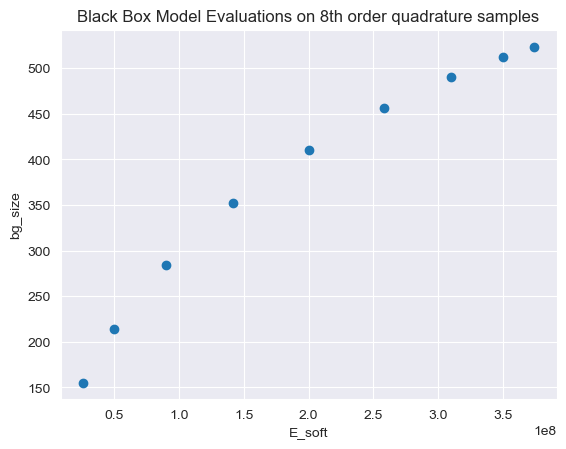

In [50]:
fig = plt.figure()
plt.scatter(E_soft_sample_sets[8], bg_size_sample_sets[8])
plt.title('Black Box Model Evaluations on 8th order quadrature samples')
plt.xlabel('E_soft')
plt.ylabel('bg_size')

In [52]:
q_surrogates = {}

for degree in degrees:
    polynomial_basis = cp.expansion.legendre(order=degree, lower=E_soft_dist.lower, upper=E_soft_dist.upper)
    #print(polynomial_basis.shape)
    polynomial_chaos_expansion = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=E_soft_sample_sets[d],
        weights=quadrature_weights[d],
        solves=bg_size_sample_sets[d]
    )
    q_surrogates[degree] = polynomial_chaos_expansion

In [53]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 1000
E_soft_test = E_soft_dist.sample(N_test)
surrogate_outputs = {}
surrogate_kdes = {}
surrogate_pdf = {}
order_offset = 2
for d in degrees:
    surrogate_outputs[d] = q_surrogates[d].__call__(E_soft_test)
    surrogate_kdes[d] = gaussian_kde(surrogate_outputs[d])
    surrogate_pdf[d] = surrogate_kdes[d](np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000))

In [48]:
E_soft_MC_10000_file = loadmat('uniform_10000/E_soft_uniform_10000.mat')
bg_size_MC_10000_file = loadmat('uniform_10000/bg_size_uniform_10000_resave.mat')
E_soft_MC_10000 = E_soft_MC_10000_file['E_soft'][:]
bg_size_MC_10000 = bg_size_MC_10000_file['bg_size'][:]

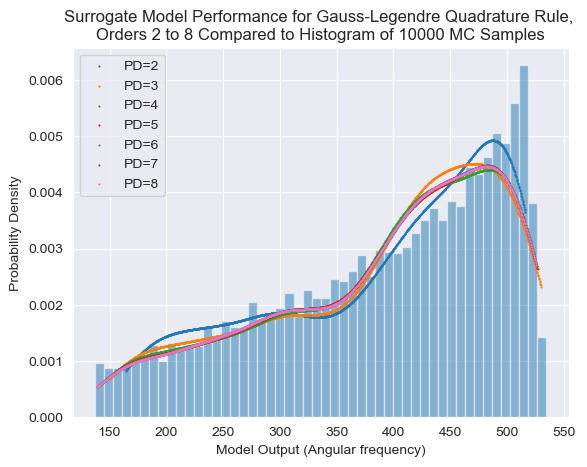

In [54]:
### PLOT SURROGATE PDF CONVERGENCE ###
plt.figure()
plt.hist(bg_size_MC_10000, bins=50, density=True, alpha=0.5)
for d in degrees:
    plot_label = 'PD='+str(d)
    plt.scatter(np.linspace(np.min(surrogate_outputs[d]), np.max(surrogate_outputs[d]), 1000), surrogate_pdf[d], label=plot_label, s=1, linewidths=0.5)
plt.xlabel("Model Output (Angular frequency)")
plt.ylabel("Probability Density")
title_str = 'Surrogate Model Performance for Gauss-Legendre Quadrature Rule, \nOrders 2 to 8 Compared to Histogram of 10000 MC Samples'
plt.title(title_str)
plt.legend(loc='best')

In [ ]:
#10000 sample case
N_kde_res = 1000
#bg_size_test_10000_pd2 = cp.call(sc_surrogates[2], E_inputs_10000.T).flatten()
#bg_size_test_10000_pd3 = cp.call(sc_surrogates[3], E_inputs_10000.T).flatten()
#bg_size_test_10000_pd4 = cp.call(sc_surrogates[4], E_inputs_10000.T).flatten()
bg_size_test_10000_pd5 = cp.call(sc_surrogates[5], E_inputs_10000.T).flatten()
bg_size_test_10000_pd6 = cp.call(sc_surrogates[6], E_inputs_10000.T).flatten()
bg_size_test_10000_pd7 = cp.call(sc_surrogates[7], E_inputs_10000.T).flatten()
bg_size_test_10000_pd8 = cp.call(sc_surrogates[8], E_inputs_10000.T).flatten()
bg_size_test_10000_pd9 = cp.call(sc_surrogates[9], E_inputs_10000.T).flatten()
bg_size_test_10000_pd10 = cp.call(sc_surrogates[10], E_inputs_10000.T).flatten()
bg_size_test_10000_pd11 = cp.call(sc_surrogates[11], E_inputs_10000.T).flatten()
bg_size_test_10000_pd12 = cp.call(sc_surrogates[12], E_inputs_10000.T).flatten()

#Make KDE PDF estimates
pce_kde_10000_pd5 = gaussian_kde(bg_size_test_10000_pd5)
pce_kde_10000_pd6 = gaussian_kde(bg_size_test_10000_pd6)
pce_kde_10000_pd7 = gaussian_kde(bg_size_test_10000_pd7)
pce_kde_10000_pd8 = gaussian_kde(bg_size_test_10000_pd8)
pce_kde_10000_pd9 = gaussian_kde(bg_size_test_10000_pd9)
pce_kde_10000_pd10 = gaussian_kde(bg_size_test_10000_pd10)
pce_kde_10000_pd11 = gaussian_kde(bg_size_test_10000_pd11)
pce_kde_10000_pd12 = gaussian_kde(bg_size_test_10000_pd12)

pce_kde_range_test_10000_pd5 = np.linspace(np.min(bg_size_test_10000_pd5), np.max(bg_size_test_10000_pd5), N_kde_res)
pce_kde_range_test_10000_pd6 = np.linspace(np.min(bg_size_test_10000_pd6), np.max(bg_size_test_10000_pd6), N_kde_res)
pce_kde_range_test_10000_pd7 = np.linspace(np.min(bg_size_test_10000_pd7), np.max(bg_size_test_10000_pd7), N_kde_res)
pce_kde_range_test_10000_pd8 = np.linspace(np.min(bg_size_test_10000_pd8), np.max(bg_size_test_10000_pd8), N_kde_res)
pce_kde_range_test_10000_pd9 = np.linspace(np.min(bg_size_test_10000_pd9), np.max(bg_size_test_10000_pd9), N_kde_res)
pce_kde_range_test_10000_pd10 = np.linspace(np.min(bg_size_test_10000_pd10), np.max(bg_size_test_10000_pd10), N_kde_res)
pce_kde_range_test_10000_pd11 = np.linspace(np.min(bg_size_test_10000_pd11), np.max(bg_size_test_10000_pd11), N_kde_res)
pce_kde_range_test_10000_pd12 = np.linspace(np.min(bg_size_test_10000_pd12), np.max(bg_size_test_10000_pd12), N_kde_res)

pce_kde_p_test_10000_pd5 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd5)
pce_kde_p_test_10000_pd6 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd6)
pce_kde_p_test_10000_pd7 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd7)
pce_kde_p_test_10000_pd8 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd8)
pce_kde_p_test_10000_pd9 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd9)
pce_kde_p_test_10000_pd10 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd10)
pce_kde_p_test_10000_pd11 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd11)
pce_kde_p_test_10000_pd12 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd12)

In [ ]:
# bg_size_test_1000_pd2 = cp.call(sc_surrogates[2], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd3 = cp.call(sc_surrogates[3], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd4 = cp.call(sc_surrogates[4], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd5 = cp.call(sc_surrogates[5], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd6 = cp.call(sc_surrogates[6], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd7 = cp.call(sc_surrogates[7], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd8 = cp.call(sc_surrogates[8], np.column_stack((E_hard, E_soft)).T)

In [ ]:
#1000 sample case
plt.scatter(bg_size_1000, bg_size_test_1000_pd2, label='PD = 2')
plt.scatter(bg_size_1000, bg_size_test_1000_pd3, label='PD = 3')
plt.scatter(bg_size_1000, bg_size_test_1000_pd4, label='PD = 4')
plt.scatter(bg_size_1000, bg_size_test_1000_pd5, label='PD = 5')
plt.scatter(bg_size_1000, bg_size_test_1000_pd6, label='PD = 6')
plt.scatter(bg_size_1000, bg_size_test_1000_pd7, label='PD = 7')
plt.scatter(bg_size_1000, bg_size_test_1000_pd8, label='PD = 8')

plt.xlabel("True output values")
plt.ylabel("Predicted output values")
plt.title("Surrogate Model Performance for Polynomial Degrees 2 to 5")
plt.legend(loc='best')

In [ ]:
#10000 sample case
#plt.scatter(bg_size_10000_1, bg_size_test_10000_pd2, label='PD = 2')
#plt.scatter(bg_size_10000_1, bg_size_test_10000_pd3, label='PD = 3')
#plt.scatter(bg_size_10000_1, bg_size_test_10000_pd4, label='PD = 4')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd5, label='PD = 5')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd6, label='PD = 6')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd7, label='PD = 7')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd8, label='PD = 8')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd9, label='PD = 9')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd10, label='PD = 10')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd11, label='PD = 11')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd12, label='PD = 12')

plt.xlabel("True output values")
plt.ylabel("Predicted output values")
plt.title("Surrogate Model Performance for Polynomial Degrees 2 to 5")
plt.legend(loc='best')

In [ ]:
pce_kde_10000 = gaussian_kde(bg_size_10000_1.flatten())
pce_kde_range_10000 = np.linspace(np.min(bg_size_10000_1), np.max(bg_size_10000_1), 1000)
pce_kde_p_10000 = pce_kde_10000(pce_kde_range_10000)

In [ ]:
plt.plot(pce_kde_range_10000, pce_kde_p_10000)
plt.hist(bg_size_10000_1, bins=50, density=True, alpha=0.5)
plt.title('Original Monte Carlo estimated PDF by Kernel Density Estimation')
plt.xlabel('Bandgap size (angular frequency)')
plt.ylabel('Probability')

In [ ]:
plt.plot(pce_kde_range_test_10000_pd5, pce_kde_p_test_10000_pd5, label='5th order PCE')
plt.hist(bg_size_test_10000_pd5, bins=50, density=True, alpha=0.5)

In [ ]:
plt.plot(pce_kde_range_10000, pce_kde_p_10000)
plt.plot(pce_kde_range_test_10000_pd5, pce_kde_p_test_10000_pd5, label='5th order PCE')
plt.plot(pce_kde_range_test_10000_pd6, pce_kde_p_test_10000_pd6, label='6th order PCE')
plt.plot(pce_kde_range_test_10000_pd7, pce_kde_p_test_10000_pd7, label='7th order PCE')
plt.plot(pce_kde_range_test_10000_pd8, pce_kde_p_test_10000_pd8, label='8th order PCE')
plt.plot(pce_kde_range_test_10000_pd9, pce_kde_p_test_10000_pd9, label='9th order PCE')
plt.plot(pce_kde_range_test_10000_pd10, pce_kde_p_test_10000_pd10, label='10th order PCE')
plt.plot(pce_kde_range_test_10000_pd11, pce_kde_p_test_10000_pd11, label='11th order PCE')
plt.plot(pce_kde_range_test_10000_pd12, pce_kde_p_test_10000_pd12, label='12th order PCE')

#plt.hist(bg_size_10000_1, bins=50, density=True, alpha=0.5)
plt.title('Estimated PDF of Surrogate Model Outputs and \nMonte Carlo samples by Kernel Density Estimation')
plt.xlabel('Bandgap size (angular frequency)')
plt.ylabel('Probability')
plt.xlim([0, 200])
plt.legend(loc='best')

In [1]:
# define the validation points
#sc_surrogates = [] * (len(collocation_schemes)*len(degrees))
sc_surrogates = {}

# create surrogate models of different polynomial orders
#for collocation_scheme in collocation_schemes:
for degree in degrees:
    print(degree)
    polynomial_basis = cp.expansion.hermite(degree, 2)
    print(polynomial_basis.shape, E_inputs_10000.T.shape, bg_size_10000_1.shape)
    polynomial_chaos_expansion = cp.fit_regression(
        polynomials=polynomial_basis,
        abscissas=E_inputs_10000.T,
        evals=bg_size_10000_1
    )
    sc_surrogates[degree] = polynomial_chaos_expansion

NameError: name 'degrees' is not defined

In [107]:
print(sc_surrogates[2], type(sc_surrogates[2]))

[2.301604010060674e-21*q0**2-9.206416040231527e-21*q0+6.904812030159683e-21] <class 'numpoly.baseclass.ndpoly'>


In [118]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 2000
#E_hard_test_1000 = E_hard_dist.sample(N_test)
#E_soft_test_1000 = E_soft_dist.sample(N_test)
E_hard_test_2000 = E_hard_dist.sample(N_test)
E_soft_test_2000 = E_soft_dist.sample(N_test)
# E_hard_test_10000 = E_hard_dist.sample(N_test)
# E_soft_test_10000 = E_soft_dist.sample(N_test)

In [119]:
savemat('E_hard_test_'+str(N_test)+'.mat', {'E_hard': E_hard_test_2000})
savemat('E_soft_test_'+str(N_test)+'.mat', {'E_soft': E_soft_test_2000})

In [99]:
#1000 sample case
bg_size_test_1000_pd2 = cp.call(sc_surrogates[2], np.column_stack((E_hard_test_1000,E_soft_test_1000)).T).flatten()
bg_size_test_1000_pd3 = cp.call(sc_surrogates[3], np.column_stack((E_hard_test_1000, E_soft_test_1000)).T).flatten()
bg_size_test_1000_pd4 = cp.call(sc_surrogates[4], np.column_stack((E_hard_test_1000, E_soft_test_1000)).T).flatten()
bg_size_test_1000_pd5 = cp.call(sc_surrogates[5], np.column_stack((E_hard_test_1000, E_soft_test_1000)).T).flatten()
bg_size_test_1000_pd6 = cp.call(sc_surrogates[6], np.column_stack((E_hard_test_1000, E_soft_test_1000)).T).flatten()
bg_size_test_1000_pd7 = cp.call(sc_surrogates[7], np.column_stack((E_hard_test_1000, E_soft_test_1000)).T).flatten()
bg_size_test_1000_pd8 = cp.call(sc_surrogates[8], np.column_stack((E_hard_test_1000, E_soft_test_1000)).T).flatten()

In [141]:
#10000 sample case
N_kde_res = 1000
#bg_size_test_10000_pd2 = cp.call(sc_surrogates[2], E_inputs_10000.T).flatten()
#bg_size_test_10000_pd3 = cp.call(sc_surrogates[3], E_inputs_10000.T).flatten()
#bg_size_test_10000_pd4 = cp.call(sc_surrogates[4], E_inputs_10000.T).flatten()
bg_size_test_10000_pd5 = cp.call(sc_surrogates[5], E_inputs_10000.T).flatten()
bg_size_test_10000_pd6 = cp.call(sc_surrogates[6], E_inputs_10000.T).flatten()
bg_size_test_10000_pd7 = cp.call(sc_surrogates[7], E_inputs_10000.T).flatten()
bg_size_test_10000_pd8 = cp.call(sc_surrogates[8], E_inputs_10000.T).flatten()
bg_size_test_10000_pd9 = cp.call(sc_surrogates[9], E_inputs_10000.T).flatten()
bg_size_test_10000_pd10 = cp.call(sc_surrogates[10], E_inputs_10000.T).flatten()
bg_size_test_10000_pd11 = cp.call(sc_surrogates[11], E_inputs_10000.T).flatten()
bg_size_test_10000_pd12 = cp.call(sc_surrogates[12], E_inputs_10000.T).flatten()

#Make KDE PDF estimates
pce_kde_10000_pd5 = gaussian_kde(bg_size_test_10000_pd5)
pce_kde_10000_pd6 = gaussian_kde(bg_size_test_10000_pd6)
pce_kde_10000_pd7 = gaussian_kde(bg_size_test_10000_pd7)
pce_kde_10000_pd8 = gaussian_kde(bg_size_test_10000_pd8)
pce_kde_10000_pd9 = gaussian_kde(bg_size_test_10000_pd9)
pce_kde_10000_pd10 = gaussian_kde(bg_size_test_10000_pd10)
pce_kde_10000_pd11 = gaussian_kde(bg_size_test_10000_pd11)
pce_kde_10000_pd12 = gaussian_kde(bg_size_test_10000_pd12)

pce_kde_range_test_10000_pd5 = np.linspace(np.min(bg_size_test_10000_pd5), np.max(bg_size_test_10000_pd5), N_kde_res)
pce_kde_range_test_10000_pd6 = np.linspace(np.min(bg_size_test_10000_pd6), np.max(bg_size_test_10000_pd6), N_kde_res)
pce_kde_range_test_10000_pd7 = np.linspace(np.min(bg_size_test_10000_pd7), np.max(bg_size_test_10000_pd7), N_kde_res)
pce_kde_range_test_10000_pd8 = np.linspace(np.min(bg_size_test_10000_pd8), np.max(bg_size_test_10000_pd8), N_kde_res)
pce_kde_range_test_10000_pd9 = np.linspace(np.min(bg_size_test_10000_pd9), np.max(bg_size_test_10000_pd9), N_kde_res)
pce_kde_range_test_10000_pd10 = np.linspace(np.min(bg_size_test_10000_pd10), np.max(bg_size_test_10000_pd10), N_kde_res)
pce_kde_range_test_10000_pd11 = np.linspace(np.min(bg_size_test_10000_pd11), np.max(bg_size_test_10000_pd11), N_kde_res)
pce_kde_range_test_10000_pd12 = np.linspace(np.min(bg_size_test_10000_pd12), np.max(bg_size_test_10000_pd12), N_kde_res)

pce_kde_p_test_10000_pd5 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd5)
pce_kde_p_test_10000_pd6 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd6)
pce_kde_p_test_10000_pd7 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd7)
pce_kde_p_test_10000_pd8 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd8)
pce_kde_p_test_10000_pd9 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd9)
pce_kde_p_test_10000_pd10 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd10)
pce_kde_p_test_10000_pd11 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd11)
pce_kde_p_test_10000_pd12 = pce_kde_10000_pd5(pce_kde_range_test_10000_pd12)

In [96]:
# bg_size_test_1000_pd2 = cp.call(sc_surrogates[2], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd3 = cp.call(sc_surrogates[3], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd4 = cp.call(sc_surrogates[4], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd5 = cp.call(sc_surrogates[5], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd6 = cp.call(sc_surrogates[6], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd7 = cp.call(sc_surrogates[7], np.column_stack((E_hard, E_soft)).T)
# bg_size_test_1000_pd8 = cp.call(sc_surrogates[8], np.column_stack((E_hard, E_soft)).T)

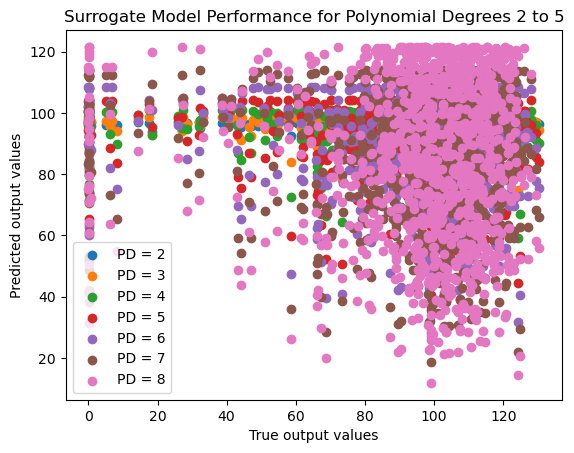

In [100]:
#1000 sample case
plt.scatter(bg_size_1000, bg_size_test_1000_pd2, label='PD = 2')
plt.scatter(bg_size_1000, bg_size_test_1000_pd3, label='PD = 3')
plt.scatter(bg_size_1000, bg_size_test_1000_pd4, label='PD = 4')
plt.scatter(bg_size_1000, bg_size_test_1000_pd5, label='PD = 5')
plt.scatter(bg_size_1000, bg_size_test_1000_pd6, label='PD = 6')
plt.scatter(bg_size_1000, bg_size_test_1000_pd7, label='PD = 7')
plt.scatter(bg_size_1000, bg_size_test_1000_pd8, label='PD = 8')

plt.xlabel("True output values")
plt.ylabel("Predicted output values")
plt.title("Surrogate Model Performance for Polynomial Degrees 2 to 5")
plt.legend(loc='best')

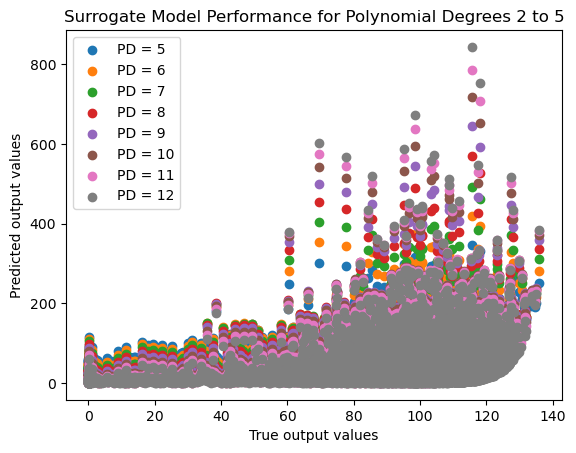

In [115]:
#10000 sample case
#plt.scatter(bg_size_10000_1, bg_size_test_10000_pd2, label='PD = 2')
#plt.scatter(bg_size_10000_1, bg_size_test_10000_pd3, label='PD = 3')
#plt.scatter(bg_size_10000_1, bg_size_test_10000_pd4, label='PD = 4')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd5, label='PD = 5')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd6, label='PD = 6')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd7, label='PD = 7')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd8, label='PD = 8')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd9, label='PD = 9')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd10, label='PD = 10')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd11, label='PD = 11')
plt.scatter(bg_size_10000_1, bg_size_test_10000_pd12, label='PD = 12')

plt.xlabel("True output values")
plt.ylabel("Predicted output values")
plt.title("Surrogate Model Performance for Polynomial Degrees 2 to 5")
plt.legend(loc='best')

In [138]:
pce_kde_10000 = gaussian_kde(bg_size_10000_1.flatten())
pce_kde_range_10000 = np.linspace(np.min(bg_size_10000_1), np.max(bg_size_10000_1), 1000)
pce_kde_p_10000 = pce_kde_10000(pce_kde_range_10000)

Text(0, 0.5, 'Probability')

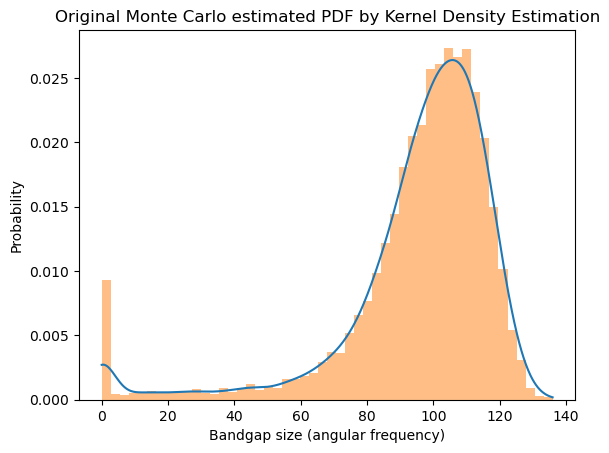

In [140]:
plt.plot(pce_kde_range_10000, pce_kde_p_10000)
plt.hist(bg_size_10000_1, bins=50, density=True, alpha=0.5)
plt.title('Original Monte Carlo estimated PDF by Kernel Density Estimation')
plt.xlabel('Bandgap size (angular frequency)')
plt.ylabel('Probability')

(array([5.88740700e-04, 1.73678507e-03, 4.18005897e-03, 6.87354768e-03,
        9.16963641e-03, 1.05237400e-02, 1.15393177e-02, 1.24224288e-02,
        1.14510066e-02, 1.09800141e-02, 1.01557771e-02, 8.96357716e-03,
        8.03631056e-03, 6.69692547e-03, 6.09346625e-03, 4.82767374e-03,
        4.23893304e-03, 3.66491086e-03, 2.78179981e-03, 2.36968132e-03,
        2.10474800e-03, 1.64847396e-03, 1.22163695e-03, 9.56703638e-04,
        7.06488840e-04, 6.77051805e-04, 5.74022183e-04, 3.97399973e-04,
        3.09088868e-04, 3.53244420e-04, 2.20777763e-04, 1.17748140e-04,
        7.35925875e-05, 5.88740700e-05, 5.88740700e-05, 5.88740700e-05,
        4.41555525e-05, 7.35925875e-05, 4.41555525e-05, 1.47185175e-05,
        4.41555525e-05, 2.94370350e-05, 4.41555525e-05, 1.47185175e-05,
        0.00000000e+00, 1.47185175e-05, 0.00000000e+00, 1.47185175e-05,
        0.00000000e+00, 1.47185175e-05]),
 array([  7.95912474,  14.75328726,  21.54744978,  28.3416123 ,
         35.13577482,  41.9299

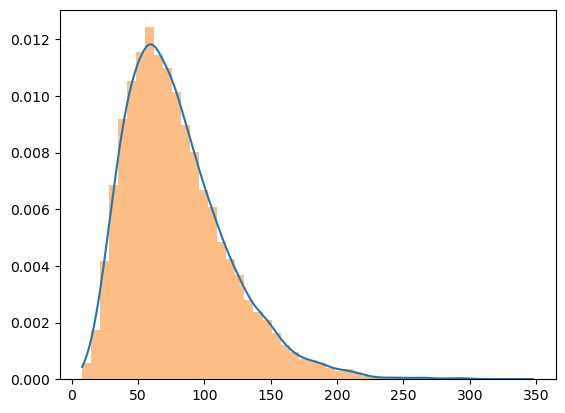

In [147]:
plt.plot(pce_kde_range_test_10000_pd5, pce_kde_p_test_10000_pd5, label='5th order PCE')
plt.hist(bg_size_test_10000_pd5, bins=50, density=True, alpha=0.5)

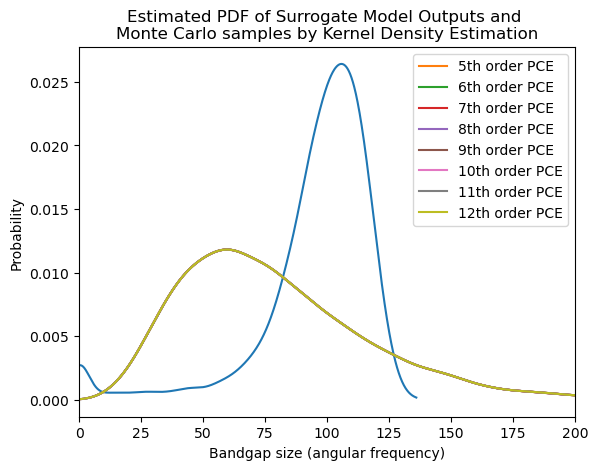

In [145]:
plt.plot(pce_kde_range_10000, pce_kde_p_10000)
plt.plot(pce_kde_range_test_10000_pd5, pce_kde_p_test_10000_pd5, label='5th order PCE')
plt.plot(pce_kde_range_test_10000_pd6, pce_kde_p_test_10000_pd6, label='6th order PCE')
plt.plot(pce_kde_range_test_10000_pd7, pce_kde_p_test_10000_pd7, label='7th order PCE')
plt.plot(pce_kde_range_test_10000_pd8, pce_kde_p_test_10000_pd8, label='8th order PCE')
plt.plot(pce_kde_range_test_10000_pd9, pce_kde_p_test_10000_pd9, label='9th order PCE')
plt.plot(pce_kde_range_test_10000_pd10, pce_kde_p_test_10000_pd10, label='10th order PCE')
plt.plot(pce_kde_range_test_10000_pd11, pce_kde_p_test_10000_pd11, label='11th order PCE')
plt.plot(pce_kde_range_test_10000_pd12, pce_kde_p_test_10000_pd12, label='12th order PCE')

#plt.hist(bg_size_10000_1, bins=50, density=True, alpha=0.5)
plt.title('Estimated PDF of Surrogate Model Outputs and \nMonte Carlo samples by Kernel Density Estimation')
plt.xlabel('Bandgap size (angular frequency)')
plt.ylabel('Probability')
plt.xlim([0, 200])
plt.legend(loc='best')